In [1]:
import copy
import pdb
import yaml
from typing import List, Union, Dict, Tuple
from PIL import Image
import random
from tqdm import tqdm
import json

import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

from data.aokvqa import AOKVQADataset
from data.sherlock import SherlockDataset
from utils.okvqa_utils import postprocess_ok_vqa_generation, lemmatize
from utils.openai_utils import openai_caller

import logging

logger = logging.getLogger(__name__)
logging.basicConfig(
        format='%(asctime)s - %(levelname)s - %(name)s - %(message)s',
        datefmt='%m/%d/%Y %H:%M:%S',
        level=logging.INFO)

/home/tejass/.conda/envs/recoverr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#dataset = AOKVQADataset('val')
dataset = SherlockDataset('eval')
device = torch.device("cuda")

qid2idx = {dataset[i]['qid']: i for i in range(len(dataset))}

02/10/2024 00:47:20 - INFO - data.sherlock - Loaded Sherlock eval dataset with 561 examples!
02/10/2024 00:47:20 - WARNING - data.sherlock - Vision/text processors not set!


In [3]:
from models.llm import LLM_CLASS_MAP
from models.vlm import VLM_CLASS_MAP
from models.qgen import QGEN_CLASS_MAP
from models.objdet import OBJDET_CLASS_MAP
from models.regcap_db import REGCAPDB_CLASS_MAP


config_file = '/net/nfs.cirrascale/mosaic/tejass/code/ReCoVERR/configs/recoverr_012524/sherlock/calibrated_instructblipft5xl_vlm/chatgpt_qgen-flant5xl_llm/lvis_objdet-qwenvl_regcap.yaml'

# Create agent and environment
config = yaml.safe_load(open(config_file))

# Load question generation model
qgen_class = config['qgen']['class_name']
qgen_model_class = QGEN_CLASS_MAP[qgen_class]
qgen_config = yaml.safe_load(open(config['qgen']['model_config_path']))
qgen_model = qgen_model_class(qgen_config, device)

# Load Object detector
objdet_class = config['objdet']['class_name']
objdet_model_class = OBJDET_CLASS_MAP[objdet_class]
objdet_config = yaml.safe_load(open(config['objdet']['model_config_path']))
objdet_model = objdet_model_class(objdet_config, device)

# Load Region captioner DB
regcapdb_class = config['regcapdb']['class_name']
regcapdb_model_class = REGCAPDB_CLASS_MAP[regcapdb_class]
regcapdb_config = yaml.safe_load(open(config['regcapdb']['model_config_path']))
regcapdb_model = regcapdb_model_class(regcapdb_config, device)

# Load VLM
vlm_class = config['vlm']['class_name']
vlm_model_class = VLM_CLASS_MAP[vlm_class]
vlm_config = yaml.safe_load(open(config['vlm']['model_config_path']))
vlm_model = vlm_model_class(vlm_config, device)
vlm_model.set_vqa_inference_params(config['vlm']['vqa_inference_params'])
vlm_model.set_caption_inference_params(config['vlm']['caption_inference_params'])
if config['vlm']['use_confidence_calibrator'] is True:
    vlm_model.set_confidence_calibrator(config['vlm']['calibrator_model_path'])

# Load LLM
llm_class = config['llm']['class_name']
llm_model_class = LLM_CLASS_MAP[llm_class]
llm_config = yaml.safe_load(open(config['llm']['model_config_path']))
llm_model = llm_model_class(llm_config, device)

models_dict = {
    'qgen': qgen_model,
    'vlm': vlm_model,
    'objdet': objdet_model,
    'llm': llm_model,
    'regcapdb': regcapdb_model
}

/home/tejass/.conda/envs/recoverr/lib/python3.10/site-packages/diffusers/models/cross_attention.py:30: FutureWarning: Importing from cross_attention is deprecated. Please import from diffusers.models.attention_processor instead.
  deprecate(
02/10/2024 00:47:28 - INFO - models.qgen - Initialized ChatGPT QuestionGenerator
02/10/2024 00:47:31 - INFO - detectron2.checkpoint.detection_checkpoint - [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/LVISv0.5-InstanceSegmentation/mask_rcnn_R_50_FPN_1x/144219072/model_final_571f7c.pkl ...
02/10/2024 00:47:31 - INFO - iopath.common.file_io - URL https://dl.fbaipublicfiles.com/detectron2/LVISv0.5-InstanceSegmentation/mask_rcnn_R_50_FPN_1x/144219072/model_final_571f7c.pkl cached in /home/tejass/.torch/iopath_cache/detectron2/LVISv0.5-InstanceSegmentation/mask_rcnn_R_50_FPN_1x/144219072/model_final_571f7c.pkl
02/10/2024 00:47:31 - INFO - fvcore.common.checkpoint - [Checkpointer] Loading from /home/tejass/.torch/iopath_c

In [ ]:
import os

directvqa_abstained_qids_file = "/net/nfs.cirrascale/mosaic/tejass/data/directvqa_abstained_qids/instructblipflant5xl-aokvqa_val_direct_answer-threshold0.66.txt"
if directvqa_abstained_qids_file and os.path.exists(directvqa_abstained_qids_file):
    directvqa_abstained_qids = set([int(qid.strip()) for qid in open(directvqa_abstained_qids_file).readlines()])
else:
    directvqa_abstained_qids = set([dataset.data[i]['qid'] for i in range(len(dataset))])
logger.info(f"Number of DirectVQA-abstained questions that we are doing search for: {len(directvqa_abstained_qids)}")
qid2idx = {str(dataset.data[i]['qid']): i for i in range(len(dataset))}
directvqa_abstained_idxs = {qid2idx[str(qid)] for qid in directvqa_abstained_qids}

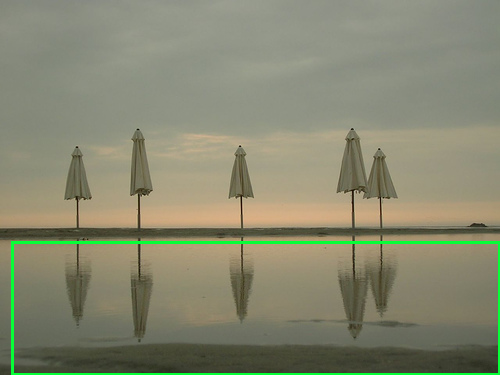

Using calibrator
QID: fc520cafd3b79e57ce844769501ac8d4
Image ID: 2390187
Question: Is the following statement true about the green highlighted box? This is a hotel pool. Options: yes, no
Annotated Answers: no (1)
VLM prediction: no


In [10]:
import random

while True:
    idx = random.randint(0, len(dataset)-1)
    #idx = int(random.choice(list(directvqa_abstained_idxs)))
    #idx = 697
    #if dataset.data[idx]['difficult_direct_answer'] is False:
    break

data = dataset[idx]
qid = data['qid']
vqa_question = data['question']
image_id = data['image_id']
image = data['raw_image']
ref_answers = data['reference_answers']
display(image)
image_path = data['image_path']
vlm_pred, _ = vlm_model.ask(image, vqa_question)

print(f"QID: {qid}")
print(f"Image ID: {image_id}")
print(f"Question: {vqa_question}")
print("Annotated Answers: {}".format(', '.join([f"{k} ({ref_answers.count(k)})" for k in set(ref_answers)])))
print(f"VLM prediction: {vlm_pred}")

In [11]:
from recoverr_012524 import run_recoverr_verifyingevidences
#from recoverr_013024 import run_recoverr_verifyingevidences

query_details = {
    'question': vqa_question,
    'image': image,
    'qid': qid,
    'image_id': image_id,
    'image_path': image_path,
}

# Initialize rollout
recoverr_config = config['recoverr']
#recoverr_config['max_evidence_collection_turns'] = 5
#recoverr_config['questions_generated_per_turn'] = 5
recoverr_config['defeasibility_delta'] = 0.2

result_dict = run_recoverr_verifyingevidences(
    query_details=query_details,
    #qgen_model=qgen_model,
    #llm_model=llm_model,
    #vlm_model=vlm_model,
    models_dict=models_dict,
    recoverr_config=recoverr_config,
    do_print=True
)

Not using calibrator
DirectVQA prediction: no with confidence 0.0339
DirectVQA hypothesis: The green highlighted box is not a hotel pool.
Using calibrator
----------------------------------------------------------------------------------------------------
Image caption: An image of a group of umbrellas on the beach with reflections in the water, and green lines drawn along them to show where they're standing. (confidence=1.0000)
P(The green highlighted box is not a hotel pool. | An image of a group of umbrellas on the beach with reflections in the water, and green lines drawn along them to show where they're standing.) = 0.8446


/home/tejass/.conda/envs/recoverr/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]



Objects in the image include umbrella.
P(The green highlighted box is not a hotel pool. | Objects in the image include umbrella.) = 0.3193

Regions in the image include a cloudy sky, a body of water, a closed white umbrella, a closed white umbrella, a white umbrella, a folded up umbrella, white closed umbrella in the middle.
P(The green highlighted box is not a hotel pool. | Regions in the image include a cloudy sky, a body of water, a closed white umbrella, a closed white umbrella, a white umbrella, a folded up umbrella, white closed umbrella in the middle.) = 0.2295
----------------------------------------------------------------------------------------------------
Evidence collection turn 0
Using calibrator

Question: What objects are present in the green highlighted box? Answer: umbrellas (conf=0.8596)
Statement: What objects are present in the green highlighted box? umbrellas.

Question: Is there any signage or indication of a hotel in the green highlighted box? Answer: no (conf=

In [ ]:
query_details

In [ ]:
r = result_dict

print(f"Target question: {vqa_question}")
print(f"DirectVQA answer (hypothesis): {r['prediction']}")
print(f"\nGathered evidences (reliable and relevant):")
numerator_total = 0
denominator_total = 0
for e in r['reliable_evidences']:
    print(f"{e['statement']}")
    rel = e['relevance']
    c = e['vlm_conf']
    p_true = e['prediction_entailment_conf']
    p_false = e['counterfactual_prediction_entailment_conf']
    contr = rel*(c*p_true + (1-c)*p_false)
    print(f"\tVLM conf={e['vlm_conf']:.4f}")
    print(f"\tP(hypothesis | true evidence) = {e['prediction_entailment_conf']:.4f}")
    print(f"\tP(hypothesis | false evidence) = {e['counterfactual_prediction_entailment_conf']:.4f}")
    print(f"\tEvidence contribution = {contr:.4f}, relevance={rel:.4f}\n")
    numerator_total += contr
    denominator_total += rel
print(f"Aggregated conf = {numerator_total/denominator_total:.4f}")

print(f"\nIf I concatenate all evidence statements together as premise and provide to NLI model,")
print(f"\tP(hypothesis | aggregated evidences) = {r['prediction_entailment_conf']:.4f}")


In [ ]:
directvqa_rollouts = json.load(open('/net/nfs.cirrascale/mosaic/tejass/experiments/recoverr/directvqa/aokvqa_direct_answer/val_outputs/instructblipflant5xl_direct_vqa-1rollouts-1145examples.json'))
llm_model.rephrasing_inference_params['max_new_tokens'] = 1

invalid_answer_rollouts = []
for qid in tqdm(directvqa_rollouts):
    
    r = directvqa_rollouts[qid][0]

    #if dataset.data[int(r['qid'])]['difficult_direct_answer'] is True:
    #    continue

    question = r['vqa_question']
    answer = r['answer']

    prompt = f"Question about image: {question} " \
        f"Prediction: {answer} " \
        f"Does the prediction make sense as a possible answer for the question? Answer yes or no: "
        #f"Is the prediction a logically valid answer for the question? Answer yes or no: "

    input_ids = llm_model.tokenizer(prompt, return_tensors='pt').input_ids.to(llm_model.device)
    output_ids = llm_model.model.generate(input_ids, **llm_model.rephrasing_inference_params)
    output_gen = llm_model.tokenizer.decode(output_ids[0], skip_special_tokens=True)
    assert output_gen in ['yes', 'no']
    if output_gen == 'no':
        invalid_answer_rollouts.append(r)

print(f"{len(invalid_answer_rollouts)} invalid predictions")

In [ ]:

r = random.choice(invalid_answer_rollouts)
#all_qids = [dataset.data[i]['qid'] for i in range(len(dataset))]
#r = qid2rollouts['595'][0] 
#qid = random.choice(all_qids)
#r = qid2rollouts[qid][0]
#qid = r['qid']
qid = 313
r = directvqa_rollouts[str(qid)][0]
idx = qid2idx[qid]

data = dataset[idx]
#print(data['qid'])
vqa_question = data['question']
image_id = data['image_id']
image = data['raw_image']
directvqa_answer = directvqa_rollouts[str(qid)][0]['answer']
directvqa_score = directvqa_rollouts[str(qid)][0]['score']
directvqa_lavescore = directvqa_rollouts[str(qid)][0]['lave_score']
directvqa_conf = directvqa_rollouts[str(qid)][0]['answer_logprobs_dict']['yn_prob']

print(f"QID: {qid}")
print(f"Image ID: {image_id}")
#print(f"Question: {r['question_with_options']}")
print(f"Question: {r['vqa_question']}")
print("Annotated Answers: {}".format(', '.join([f"{k} ({v:.2f})" for k, v in dataset[idx]['score_dict'].items()])))
print(f"DirectVQA predicted answer: {directvqa_answer}, conf={directvqa_conf:.4f} (score={directvqa_score:.2f}, LAVE score={directvqa_lavescore:.2f})")
print(f"ReCoVERR predicted answer: {r['answer']} (score={r['score']:.2f}, LAVE score={r['lave_score']:.2f})")
display(image)
print(r['lave_reasoning'])
print(data['image_path'])

In [ ]:
llm_model.rephrasing_inference_params['max_new_tokens'] = 30

prompt = f"Question about image: {vqa_question} " \
        f"Prediction: {answer} " \
        f"Does the prediction make sense as a possible answer for the question? Answer yes or no, along with an explanation: "
        #f"Is the prediction a logically valid answer for the question? Answer yes or no: "

input_ids = llm_model.tokenizer(prompt, return_tensors='pt').input_ids.to(llm_model.device)
output_ids = llm_model.model.generate(input_ids, **llm_model.rephrasing_inference_params)
output_gen = llm_model.tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(output_gen)

In [ ]:
multi_answers, answer_confs = vlm_model.ask_multiplequestions_samplemultianswers(image, [vqa_question], num_answers=5)
for i in range(5):
    print(multi_answers[i], vlm_model.get_answer_confidence(image, [vqa_question], [multi_answers[i]])[0])

In [ ]:
for a in multi_answers[1:]:
    #print(a)
    prompt = f"Question about image: {question} " \
        f"Answer A: {directvqa_answer} " \
        f"Answer B: {a}" \
        f"Is answer B a more specific answer than answer A for the given question? Answer yes or no: "
    input_ids = llm_model.tokenizer(prompt, return_tensors='pt').input_ids.to(llm_model.device)
    output_ids = llm_model.model.generate(input_ids, **llm_model.rephrasing_inference_params)
    output_gen = llm_model.tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print(f"Is {a} more specific than {directvqa_answer}? LLM: {output_gen}")

In [ ]:
multi_answers